In [94]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

# To list all indices, do 
# curl -XGET 'http://atlas-kibana.mwt2.org:9200/_settings?pretty=1' 
ind="jobs_archive_2016*"

In [95]:
# one can also use the following command to see the return json data.
# curl -XGET 'http://atlas-kibana.mwt2.org:9200/jobs_archive_2016*/_search?pretty=1' -d'
# { the json in 'x' (below)}

x = {
  "size": 2000,
  "fields": ["wall_time","jobstatus","modificationtime","modificationhost"],
  "query": {
    "bool": {
    "should": [{ "match": { "computingsite": "ANALY_SLAC" }},
               { "wildcard": { "modificationhost": "fell*" }},
               { "match": { "jobstatus": "finished" }}]
    }
  }
}

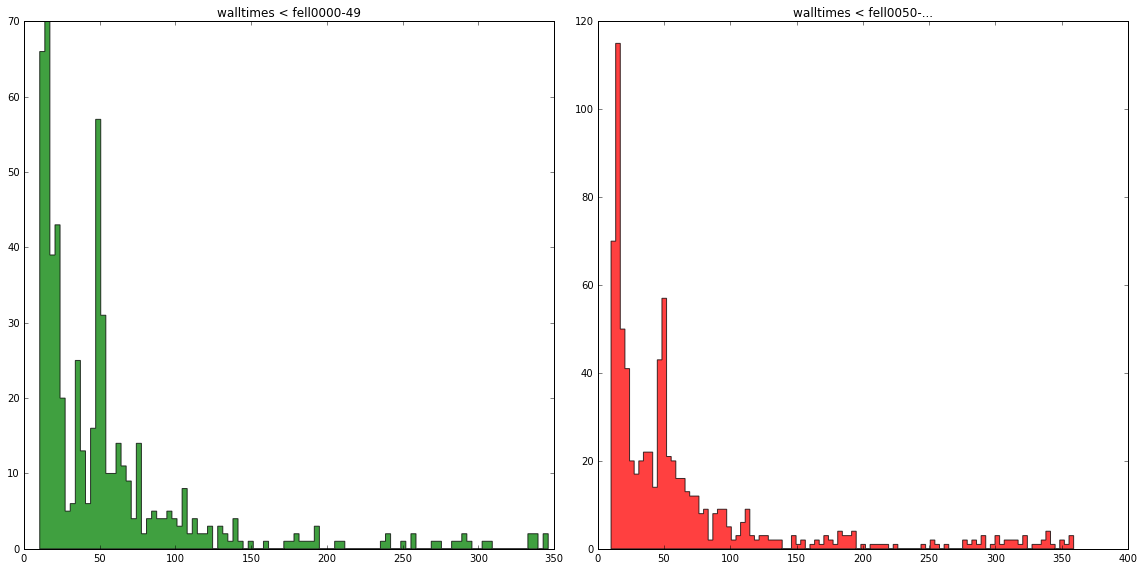

In [98]:
rc = es.search(index=ind, body=x, analyze_wildcard=True)
walltimes0 = []
walltimes1 = []
timerange0 = datetime.strptime("2016-02-01","%Y-%m-%d")
timerange1 = datetime.strptime("2016-04-14","%Y-%m-%d")
for job in rc['hits']['hits']:
  timestamp = datetime.strptime(job['fields']['modificationtime'][0],"%Y-%m-%dT%H:%M:%S")
  if (timestamp<timerange0 or timestamp>timerange1):
    continue                               
  hostname = job['fields']['modificationhost'][0]
  hostnumb = int(re.sub("fell","",hostname))
  wallt = job['fields']['wall_time'][0]/60
  #print ("hostname: %s, walltime: %.2f" % (hostn, wallt))
  if (wallt<10 or wallt>360):
    continue
  if hostnumb < 50:
    walltimes0 += [wallt]
  else:
    walltimes1 += [wallt]

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))
ax0.hist(walltimes0, 100, histtype='stepfilled', facecolor='g', alpha=0.75)
ax0.set_title('walltimes < fell0000-49')
ax1.hist(walltimes1, 100, histtype='stepfilled', facecolor='r', alpha=0.75)
ax1.set_title('walltimes < fell0050-...')
plt.tight_layout()
plt.show()